In [2]:
import pickle
import helpsk as hlp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder  # , LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
# from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

# Load Data

In [3]:
parser = hlp.sklearn_eval.SearchCVParser.from_yaml_file(yaml_file_name = 'Run 1 - Random Forest - BayesSearchCV.yaml')
parser.best_primary_score_params

{'max_features': 0.001062755754765592,
 'n_estimators': 4201,
 'encoder': 'CustomOrdinalEncoder()',
 'imputer': 'SimpleImputer()',
 'scaler': 'StandardScaler()'}

In [4]:
with open('../X_train.pkl', 'rb') as handle:
    X_train = pickle.load(handle)
    print(X_train.shape)

with open('../y_train.pkl', 'rb') as handle:
    y_train = pickle.load(handle)
    print(len(y_train))

with open('../X_test.pkl', 'rb') as handle:
    X_test = pickle.load(handle)
    print(X_test.shape)

with open('../y_test.pkl', 'rb') as handle:
    y_test = pickle.load(handle)
    print(len(y_test))

(800, 20)
800
(200, 20)
200


In [5]:
X_train.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
29,NaN,NaN,delayed previously,business,0.0,<100,>=7,3.0,male single,none,4.0,no known property,63.0,none,own,2.0,skilled,1.0,yes,yes
535,>=200,21.0,critical/other existing credit,education,2319.0,<100,<1,2.0,male div/sep,none,1.0,car,33.0,none,rent,1.0,skilled,1.0,none,yes
695,no checking,6.0,existing paid,used car,1236.0,500<=X<1000,1<=X<4,2.0,male single,none,4.0,life insurance,50.0,none,rent,1.0,skilled,1.0,none,yes
557,no checking,21.0,no credits/all paid,new car,5003.0,no known savings,1<=X<4,1.0,female div/dep/mar,none,4.0,life insurance,29.0,bank,own,2.0,skilled,1.0,yes,yes
836,no checking,12.0,existing paid,radio/tv,886.0,no known savings,1<=X<4,4.0,female div/dep/mar,none,2.0,car,21.0,none,own,1.0,skilled,1.0,none,yes


In [6]:
y_train[0:10]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [7]:
X_test.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
521,<0,18.0,existing paid,radio/tv,3190.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,24.0,none,own,1.0,skilled,1.0,none,yes
737,<0,18.0,existing paid,new car,4380.0,100<=X<500,1<=X<4,3.0,male single,none,4.0,car,35.0,none,own,1.0,unskilled resident,2.0,yes,yes
740,<0,24.0,all paid,new car,2325.0,100<=X<500,4<=X<7,2.0,male single,none,3.0,car,32.0,bank,own,1.0,skilled,1.0,none,yes
660,>=200,12.0,existing paid,radio/tv,1297.0,<100,1<=X<4,3.0,male mar/wid,none,4.0,real estate,23.0,none,rent,1.0,skilled,1.0,none,yes
411,no checking,33.0,critical/other existing credit,used car,7253.0,<100,4<=X<7,3.0,male single,none,2.0,car,35.0,none,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes


In [8]:
y_test[0:10]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Training and Test Data

In [9]:
y_train[0:10]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [10]:
numeric_columns = hlp.pandas.get_numeric_columns(X_train)
non_numeric_columns = hlp.pandas.get_non_numeric_columns(X_train)
print(numeric_columns)
print(non_numeric_columns)

['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


In [11]:
parser.best_primary_score_params

{'max_features': 0.001062755754765592,
 'n_estimators': 4201,
 'encoder': 'CustomOrdinalEncoder()',
 'imputer': 'SimpleImputer()',
 'scaler': 'StandardScaler()'}

In [12]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

In [13]:
non_numeric_pipeline = Pipeline([
    ('encoder', hlp.sklearn_pipeline.CustomOrdinalEncoder()),
])

In [14]:
from sklearn.compose import ColumnTransformer
transformations_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_columns),
    ('non_numeric', non_numeric_pipeline, non_numeric_columns)
])

# Model

In [15]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(
    max_features=0.01,
    n_estimators=2500,
    random_state=42,
)

In [16]:
full_pipeline = Pipeline([
    ('prep', transformations_pipeline),
    ('model', random_forest_model)
])

In [17]:
# Show the levels of pipelines/transformers/model
full_pipeline.named_steps

{'prep': ColumnTransformer(transformers=[('numeric',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', StandardScaler())]),
                                  ['duration', 'credit_amount',
                                   'installment_commitment', 'residence_since',
                                   'age', 'existing_credits',
                                   'num_dependents']),
                                 ('non_numeric',
                                  Pipeline(steps=[('encoder',
                                                   CustomOrdinalEncoder())]),
                                  ['checking_status', 'credit_history',
                                   'purpose', 'savings_status', 'employment',
                                   'personal_status', 'other_parties',
                                   'property_magnitude', 'other_payment_plans',
                                  

In [18]:
fitted_pipeline = full_pipeline.fit(X_train, y_train)

In [19]:
fitted_pipeline.predict(X_test)

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1])

In [20]:
fitted_pipeline.predict_proba(X_test)

array([[0.4368, 0.5632],
       [0.356 , 0.644 ],
       [0.6244, 0.3756],
       [0.3364, 0.6636],
       [0.144 , 0.856 ],
       [0.3376, 0.6624],
       [0.1008, 0.8992],
       [0.4152, 0.5848],
       [0.1152, 0.8848],
       [0.202 , 0.798 ],
       [0.186 , 0.814 ],
       [0.4276, 0.5724],
       [0.2112, 0.7888],
       [0.576 , 0.424 ],
       [0.7116, 0.2884],
       [0.3456, 0.6544],
       [0.2016, 0.7984],
       [0.1648, 0.8352],
       [0.5212, 0.4788],
       [0.3028, 0.6972],
       [0.2784, 0.7216],
       [0.2604, 0.7396],
       [0.1244, 0.8756],
       [0.0248, 0.9752],
       [0.0616, 0.9384],
       [0.4112, 0.5888],
       [0.538 , 0.462 ],
       [0.4092, 0.5908],
       [0.2784, 0.7216],
       [0.196 , 0.804 ],
       [0.324 , 0.676 ],
       [0.214 , 0.786 ],
       [0.3704, 0.6296],
       [0.2652, 0.7348],
       [0.2172, 0.7828],
       [0.2748, 0.7252],
       [0.4956, 0.5044],
       [0.228 , 0.772 ],
       [0.1104, 0.8896],
       [0.4852, 0.5148],


In [21]:
y_test

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1])

## Training Set Evaluation

Understand the nature/degree of model overfitting by comparing to `Test Set Evaluation`

In [22]:
predicted_scores = fitted_pipeline.predict_proba(X_train)[:, 1]

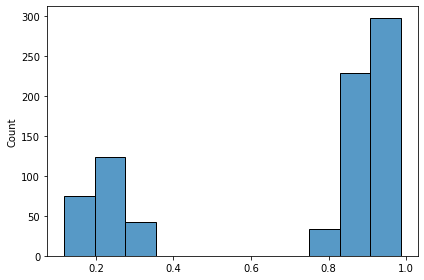

In [23]:
sns.histplot(predicted_scores)
plt.tight_layout()

In [24]:

evaluator = hlp.sklearn_eval.TwoClassEvaluator(
    actual_values=y_train,
    predicted_scores=predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)

In [25]:
evaluator.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,1.000,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,1.000,"100.0% of positive instances were correctly identified.; i.e. 559 ""Good"" labels were correctly identified out of 559 instances; a.k.a Sensitivity/Recall"
True Negative Rate,1.000,"100.0% of negative instances were correctly identified.; i.e. 241 ""Bad"" labels were correctly identified out of 241 instances"
False Positive Rate,0.000,"0.0% of negative instances were incorrectly identified as positive; i.e. 0 ""Bad"" labels were incorrectly identified as ""Good"", out of 241 instances"
False Negative Rate,0.000,"0.0% of positive instances were incorrectly identified as negative; i.e. 0 ""Good"" labels were incorrectly identified as ""Bad"", out of 559 instances"
Positive Predictive Value,1.000,"When the model claims an instance is positive, it is correct 100.0% of the time; i.e. out of the 559 times the model predicted ""Good"", it was correct 559 times; a.k.a precision"
Negative Predictive Value,1.000,"When the model claims an instance is negative, it is correct 100.0% of the time; i.e. out of the 241 times the model predicted ""Bad"", it was correct 241 times"
F1 Score,1.000,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,1.000,100.0% of instances were correctly identified
Error Rate,0.000,0.0% of instances were incorrectly identified


In [26]:
del predicted_scores

## Test Set Evaluation

In [27]:
predicted_scores = fitted_pipeline.predict_proba(X_test)[:, 1]

In [28]:
predicted_scores[0:10]

array([0.5632, 0.644 , 0.3756, 0.6636, 0.856 , 0.6624, 0.8992, 0.5848,
       0.8848, 0.798 ])

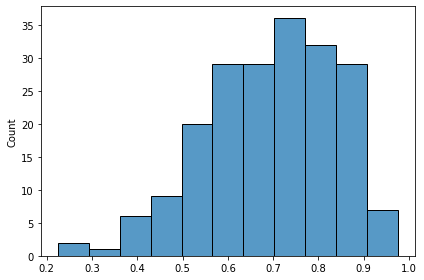

In [29]:
sns.histplot(predicted_scores)
plt.tight_layout()

In [30]:
y_test_cat = pd.Series(y_test).replace({1: 'Defaulted', 0: 'Not Defaulted'})
y_test_cat.head()

0    Not Defaulted
1        Defaulted
2        Defaulted
3        Defaulted
4        Defaulted
dtype: object

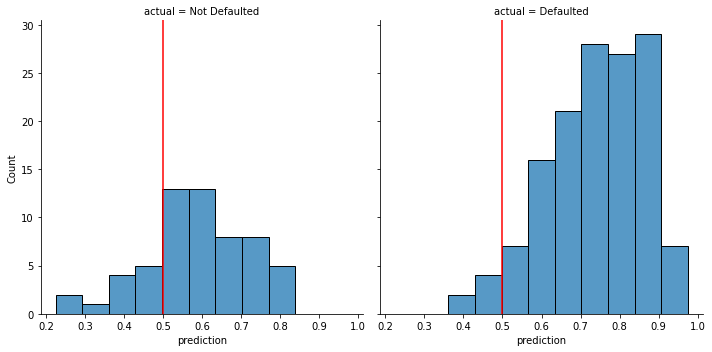

In [31]:
axes = sns.displot(
    pd.DataFrame({
        'prediction': predicted_scores,
        'actual': y_test_cat
    }),
    x='prediction',
    col='actual'
)
for axis in axes.axes.flat:
    axis.axvline(x=0.5, ymin=0, ymax=100, color='red')
plt.tight_layout()

In [32]:
del y_test_cat
del axes

In [33]:
evaluator = hlp.sklearn_eval.TwoClassEvaluator(
    actual_values=y_test,
    predicted_scores=predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)

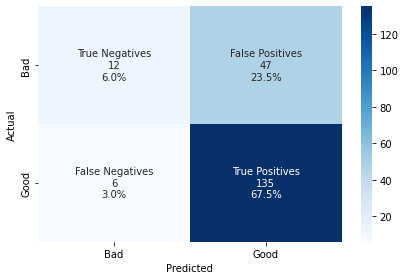

In [34]:
evaluator.plot_confusion_matrix()

In [35]:
evaluator.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,0.799,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,0.957,"95.7% of positive instances were correctly identified.; i.e. 135 ""Good"" labels were correctly identified out of 141 instances; a.k.a Sensitivity/Recall"
True Negative Rate,0.203,"20.3% of negative instances were correctly identified.; i.e. 12 ""Bad"" labels were correctly identified out of 59 instances"
False Positive Rate,0.797,"79.7% of negative instances were incorrectly identified as positive; i.e. 47 ""Bad"" labels were incorrectly identified as ""Good"", out of 59 instances"
False Negative Rate,0.043,"4.3% of positive instances were incorrectly identified as negative; i.e. 6 ""Good"" labels were incorrectly identified as ""Bad"", out of 141 instances"
Positive Predictive Value,0.742,"When the model claims an instance is positive, it is correct 74.2% of the time; i.e. out of the 182 times the model predicted ""Good"", it was correct 135 times; a.k.a precision"
Negative Predictive Value,0.667,"When the model claims an instance is negative, it is correct 66.7% of the time; i.e. out of the 18 times the model predicted ""Bad"", it was correct 12 times"
F1 Score,0.836,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,0.735,73.5% of instances were correctly identified
Error Rate,0.265,26.5% of instances were incorrectly identified


Compare results against scores if we predicted all `Good`

In [36]:
dummy_predicted_scores = np.array([0.99] * len(predicted_scores))

In [37]:
dummy_eval = hlp.sklearn_eval.TwoClassEvaluator(
    actual_values=y_test,
    predicted_scores=dummy_predicted_scores,
    labels=('Bad', 'Good'),
    score_threshold=0.5
)
dummy_eval.all_metrics_df(return_style=True, round_by=3)

,Scores,Details
AUC,0.500,Area under the ROC curve (true pos. rate vs false pos. rate); ranges from 0.5 (purely random classifier) to 1.0 (perfect classifier)
True Positive Rate,1.000,"100.0% of positive instances were correctly identified.; i.e. 141 ""Good"" labels were correctly identified out of 141 instances; a.k.a Sensitivity/Recall"
True Negative Rate,0.000,"0.0% of negative instances were correctly identified.; i.e. 0 ""Bad"" labels were correctly identified out of 59 instances"
False Positive Rate,1.000,"100.0% of negative instances were incorrectly identified as positive; i.e. 59 ""Bad"" labels were incorrectly identified as ""Good"", out of 59 instances"
False Negative Rate,0.000,"0.0% of positive instances were incorrectly identified as negative; i.e. 0 ""Good"" labels were incorrectly identified as ""Bad"", out of 141 instances"
Positive Predictive Value,0.705,"When the model claims an instance is positive, it is correct 70.5% of the time; i.e. out of the 200 times the model predicted ""Good"", it was correct 141 times; a.k.a precision"
Negative Predictive Value,0.000,"When the model claims an instance is negative, it is correct 0.0% of the time; i.e. out of the 0 times the model predicted ""Bad"", it was correct 0 times"
F1 Score,0.827,"The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0."
Accuracy,0.705,70.5% of instances were correctly identified
Error Rate,0.295,29.5% of instances were incorrectly identified


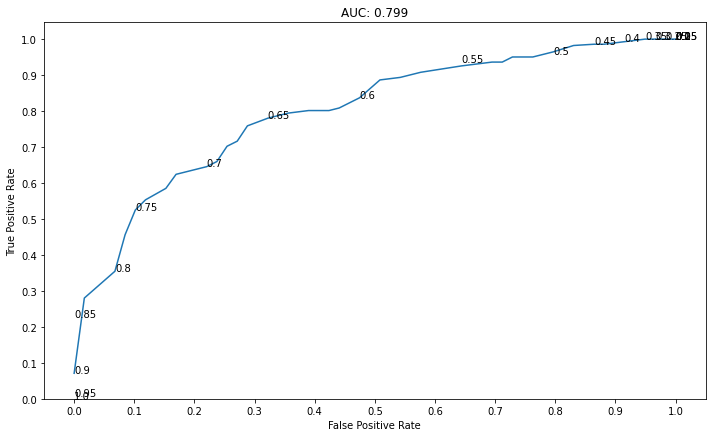

In [38]:
evaluator.plot_auc_curve()
plt.grid()

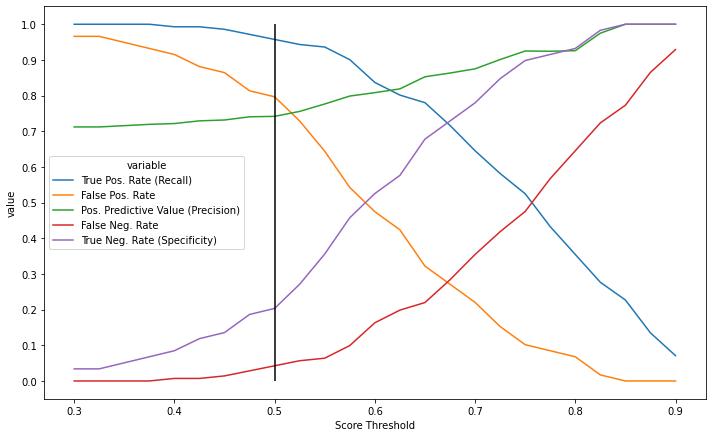

In [39]:
evaluator.plot_threshold_curves()
plt.grid()

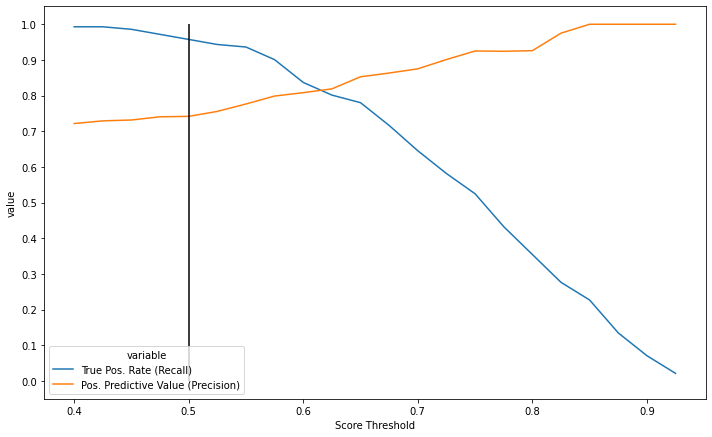

In [40]:
evaluator.plot_precision_recall_tradeoff(score_threshold_range=(0.4, 0.95))
plt.grid()

In [41]:
evaluator.calculate_lift_gain(return_style=True, include_all_info=True)

,# of Obs.,# of Pos. Events,Cumul. Pos. Events,Gain,Lift
Percentile,,,,,
5,10,10,10,0.07,1.42
10,10,10,20,0.14,1.42
15,10,10,30,0.21,1.42
20,10,9,39,0.28,1.38
25,10,7,46,0.33,1.30
30,10,10,56,0.40,1.32
35,10,9,65,0.46,1.32
40,10,9,74,0.52,1.31
45,10,7,81,0.57,1.28


In [42]:
del predicted_scores

# Feature Importance

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [53]:
from sklearn.inspection import permutation_importance
import time

estimator = full_pipeline

start_time = time.time()
result = permutation_importance(
    estimator, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

feature_names = X_train.columns.to_list()
forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

Elapsed time to compute the importances: 54.368 seconds


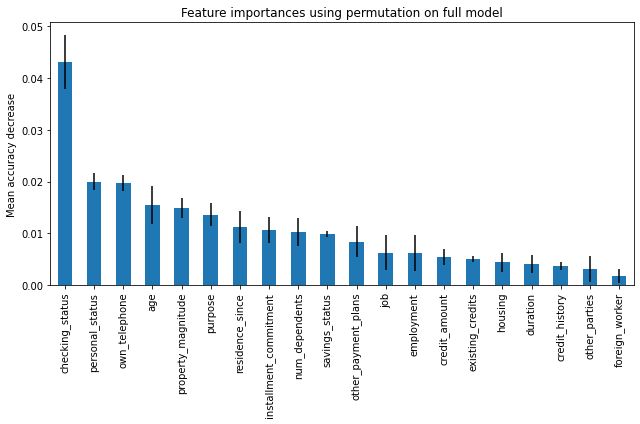

In [54]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.set_size_inches(9, 6)
fig.tight_layout()
plt.show()